In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [49]:
# чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

# Baseline Prophet

In [50]:
# обучение модели baseline prophet
bl_prophet = Prophet()
bl_prophet.fit(df_train)

02:31:56 - cmdstanpy - INFO - Chain [1] start processing
02:31:57 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
future = bl_prophet.make_future_dataframe(periods=365, freq='D')
forecast = bl_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2716,2024-03-05,13.919675,11.644143,16.606642
2717,2024-03-06,14.038301,11.654573,16.667687
2718,2024-03-07,14.093533,11.586812,16.442775
2719,2024-03-08,14.149100,11.515892,16.639993
2720,2024-03-09,14.921460,12.520774,17.395807
2721,2024-03-10,14.973605,12.665582,17.624536
2722,2024-03-11,14.270169,11.912279,16.658619
2723,2024-03-12,14.317111,11.816485,16.772104
2724,2024-03-13,14.401140,12.080244,16.839691
2725,2024-03-14,14.420674,11.956075,16.926123


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


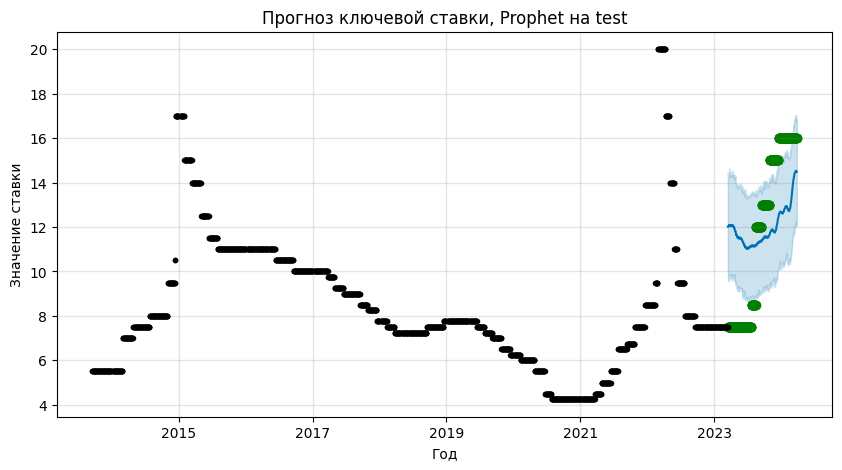

In [52]:
# смотрим совпадение фактического курса с предсказанным курсом baseline prophet
fig, ax = plt.subplots(figsize= (10, 5))

predict = bl_prophet.predict(df_test)
fig = bl_prophet.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

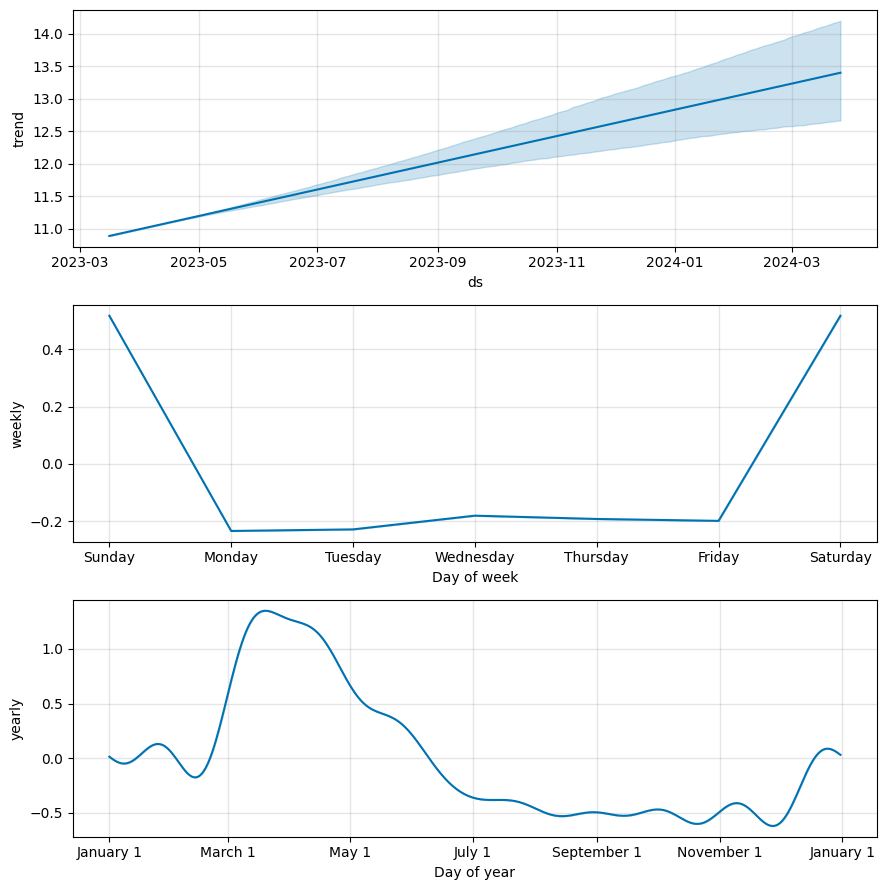

In [53]:
# смотрим тренд, годовые и сезонные признаки
fig = bl_prophet.plot_components(predict)
plt.show()

In [54]:
# выводиим метрики для оценкии baseline prophet 
get_metrics = get_metrics(y_test=df_test['y'], y_pred=predict['yhat'], name='Baseline Prophet')
get_metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Baseline Prophet,2.913884,0.293764,9.792083,3.12923


1. Mean Absolute Error (MAE) - Среднее абсолютное отклонение позволяет оценить среднее абсолютное отклонение прогнозов от фактических значений. Чем ниже MAE, тем лучше модель.
2. Mean Absolute Percentage Error (MAPE) - Среднее абсолютное процентное отклонение показывает средний процент ошибки прогноза от фактических значений. Чем ниже MAPE, тем лучше.
3. Mean Squared Error (MSE) - Среднеквадратичное отклонение предоставляет информацию о среднеквадратичном отклонении прогнозов от фактических значений. Чем ниже MSE, тем лучше модель.
4. Root Mean Squared Error (RMSE) - Квадратный корень из MSE помогает интерпретировать стандартное отклонение прогнозов от фактических значений.

# Tuning Prophet

## Hyperparameter tuning

In [ ]:
# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [ ]:
# выводиим метрики для оценкии tuning prophet 
#metrics = pd.concat([metrics, get_metrics(y_test=df_cv['y'], y_pred=df_cv['yhat'], name='CV Prophet')])
#metrics